
## 拡張カルマンフィルタによる自己位置推定 


拡張カルマンフィルタを移動ロボットの自己位置推定に利用するケースのシミュレーションをJuliaで行いgifを生成。
確率ロボティクスの7章の7.4の擬似コードを実装した内容。

<a href="https://myenigma.hatenablog.com/entry/20130413/1365826157" target="_blank">Atsushi Sakaiさんの拡張カルマンフィルタの記事</a>などがわかりやすい。コードとかも参考にした。
Juliaでのgif生成は<a href="https://nbviewer.jupyter.org/gist/genkuroki/3d6dbf52a3e52eb7c664bc88632c81d3" target="_blank">黒木さんの記事</a>を参考にしてPlots.gr() を使った。

---------


### 動作モデルの設定
#### 状態方程式
今回は拡張カルマンフィルタなので，
$$
  \begin{align*}
    x_{t} =  A x_{t-1} + B u_{t} + \epsilon_t 
  \end{align*}
$$
ではなく，非線形なプラント
$$
  \begin{align*}
    x_{t} =  g\left( x_{t-1}, u_{t} \right) + \epsilon_t 
  \end{align*}
$$
を考える。
<div style="text-align: center;">
ここで確率変数$\epsilon_t$はガウス分布に従うベクトルで，平均値は$0$で共分散行列は$R_t$で表される。

今回は次式で表される移動ロボットの動作モデルを用いる。

$$
  \begin{align*}
    \left(
      \begin{array}{c}
        x_{t}\\
        y_{t} \\
        \theta_{t}
      \end{array}
    \right) = 
    \left(
      \begin{array}{c}
        x_{t-1} \\
        y_{t-1} \\
        \theta_{t-1}
      \end{array}
    \right) + 
    \left(
      \begin{array}{c}
        - \frac{\hat v_t}{\hat \omega_t} \sin{\theta_{t-1}}  + \frac{\hat v_t}{\hat \omega_t} \sin \left( \theta_{t-1} + \hat \omega_t \Delta t \right) \\
          \frac{\hat v_t}{\hat \omega_t} \cos{\theta_{t-1}} + \frac{\hat v_t}{\hat \omega_t} \cos \left( \theta_{t-1} + \hat \omega_t \Delta t \right) \\
        \hat \omega_{t} \Delta t
      \end{array}
    \right) + N\left( 0, R_t \right)
  \end{align*}
$$



</div>

ここで，右辺からランダム雑音を除いた項を下のように$g(u_t, x_{t-1})$とおく


$$
  \begin{align*}
    g(u_t, x_{t-1}) = 
    \left(
      \begin{array}{c}
        x_{t-1} \\
        y_{t-1} \\
        \theta_{t-1}
      \end{array}
    \right) + 
    \left(
      \begin{array}{c}
        - \frac{\hat v_t}{\hat \omega_t} \sin{\theta_{t-1}}  + \frac{\hat v_t}{\hat \omega_t} \sin \left( \theta_{t-1} + \hat \omega_t \Delta t \right) \\
          \frac{\hat v_t}{\hat \omega_t} \cos{\theta_{t-1}} + \frac{\hat v_t}{\hat \omega_t} \cos \left( \theta_{t-1} + \hat \omega_t \Delta t \right) \\
        \hat \omega_{t} \Delta t
      \end{array}
    \right)
  \end{align*}
$$

次のセクションで$g(u_t, x_{t-1})$の線形化について説明し，その次で$ N\left( 0, R_t \right) $について説明する。



#### 状態方程式の線形化
カルマンフィルタを拡張カルマンフィルタに拡張するために，非線形関数である$g(u_t, x_{t-1})$を線形化する。

上式の$g(u_t, x_{t-1})$に対して，毎回，一次までテイラー展開して以下のように線形関数に近似する。

$$
  \begin{align*}
    g(u_t, x_{t-1}) \approx g(u_t, \mu_{t-1}) + \frac{\partial g(u_t, \mu_{t-1})}{\partial x_{t-1} } (x_{t-1} - \mu_{t-1})
  \end{align*}
$$

この$\dfrac{\partial g(u_t, \mu_{t-1})}{\partial x_{t-1} }$は$G_t$で表され，ヤコビ行列と呼ばれる。
今回の動作モデルについてヤコビ行列$G_t$を計算すると次式のようになる。

$$
  \begin{align*}
    G_t & = \frac{\partial g(u_t, \mu_{t-1})}{\partial x_{t-1} } \\
          & = \left(
                  \begin{array}{ccc}
                    \frac{\partial x' }{\partial \mu_{t-1,x}} & \frac{\partial x' }{\partial \mu_{t-1,y}} & \frac{\partial x' }{\partial \mu_{t-1,\theta}}\\
                    \frac{\partial y' }{\partial \mu_{t-1,x}} & \frac{\partial y' }{\partial \mu_{t-1,y}} & \frac{\partial y' }{\partial \mu_{t-1,\theta}}\\
                    \frac{\partial \theta' }{\partial \mu_{t-1,x}} & \frac{\partial \theta' }{\partial \mu_{t-1,y}} & \frac{\partial \theta' }{\partial \mu_{t-1,\theta}}
                  \end{array}
                \right)\\
          & = \left(
                  \begin{array}{ccc}
                    1 & 0 & \frac{v_t}{\omega_t} \left( -\cos{\mu_{t-1, \theta}} + \cos{\left( \mu_{t-1, \theta} + \omega_t \Delta t \right)} \right)\\
                    0 & 1 & \frac{v_t}{\omega_t} \left( -\sin{\mu_{t-1, \theta}} + \sin{\left( \mu_{t-1, \theta} + \omega_t \Delta t \right)} \right)\\
                    0 & 0 & 1
                  \end{array}
                \right)
  \end{align*}
$$


#### 制御入力に関する共分散行列
動作モデルの右辺の$ N\left( 0, R_t \right) $について考えたいが，今回の移動ロボットモデルの入力値は速度$v$と回転速度$\omega$で与える。

このモデルでは，入力の共分散行列は下のように入力$v^2$や$\omega^2$に依存する値で表現される。



$$
  \left(
    \begin{array}{c}
      \hat v_t \\
      \hat \omega_t
    \end{array}
  \right) = 
  \left(
    \begin{array}{c}
      v_t \\
      \omega_t
    \end{array}
  \right) + 
  \left(
    \begin{array}{c}
      \epsilon_{\alpha_1 v^2_t + \alpha_2 \omega^2_t} \\
      \epsilon_{\alpha_3 v^2_t + \alpha_4 \omega^2_t}
    \end{array}
  \right) = 
  \left(
    \begin{array}{c}
      v_t \\
      \omega_t
    \end{array}
  \right) + N \left( 0, M_t \right)
$$

しかし，ノイズが$v$，$\omega$によって張られる制御空間における定義になっているため，実装の際には状態量$x$，$y$，$\theta$で張られる状態空間の行列に変換する必要がある。

    


制御空間における動作雑音の共分散行列$M_t$は次式のように示される。
$$
  M_t = 
  \left(
    \begin{array}{cc}
      \alpha_1 v^2_t + \alpha_2 \omega^2_t &                                                        0\\
                                                             0 & \alpha_3 v^2_t + \alpha_4 \omega^2_t
    \end{array}
  \right) 
$$
制御空間から状態空間への変換は，線形近似で行われる。この近似に用いるヤコビ行列$V_t$は下のように求められる。

$$
  \begin{align*}
    V_t & = \frac{\partial g(u_t, \mu_{t-1})}{\partial u_t } \\
          & = \left(
                  \begin{array}{cc}
                    \frac{\partial x' }{\partial v_t }        & \frac{\partial x' }{\partial \omega_t } \\
                    \frac{\partial y' }{\partial v_t }        & \frac{\partial y' }{\partial \omega_t } \\
                    \frac{\partial \theta' }{\partial v_t } & \frac{\partial \theta' }{\partial \omega_t } 
                  \end{array}
                \right)\\
          & = \left(
                  \begin{array}{cc}
                    \frac{-\sin \theta + \sin{\left( \theta + \omega_t \Delta t\right) } }{\omega_t}   &  \frac{v_t \left( -\sin \theta + \sin\left( \theta + \omega_t \Delta t\right) \right) }{\omega^2_t}  + \frac{v_t\cos{\left( \theta + \omega_t \Delta t\right) \Delta t } }{\omega_t} \\
                    \frac{\cos \theta - \cos{\left( \theta + \omega_t \Delta t\right) } }{\omega_t}   & -\frac{v_t \left( \cos \theta - \cos\left( \theta + \omega_t \Delta t\right) \right) }{\omega^2_t}  + \frac{v_t\sin{\left( \theta + \omega_t \Delta t\right) \Delta t } }{\omega_t} \\
                    0 & \Delta t
                  \end{array}
                \right)
  \end{align*}
$$
このヤコビ行列により，制御空間で表現されていたノイズの状態空間への変換が可能となり，下のように入力の雑音に関する共分散行列が表される。
$$R_t = V_t M_t V_t^T$$

### 観測モデルの設定

#### 出力方程式
$$
  \begin{align*}
    z_{t} =  C x_{t} + \delta_t
  \end{align*}
$$
ではなく
$$
  \begin{align*}
    z_{t} =  h\left( x_{t} \right) + \delta_t 
  \end{align*}
$$
を考える。
<div style="text-align: center;">
ここで確率変数$\delta_t$はガウス分布に従うベクトルで，平均値は$0$で共分散行列は$Q_t$で表される。
</div>

ロボットは現在地から半径（radius）の範囲に存在する目印（landmark）を認識する。
今回は，$i$番目のlandmarkに対して以下のような観測値$z^i$を返す観測モデルを考える。

$$
  \begin{align*}
    z^i & = \left(
                 \begin{array}{c}
                    r^i \\
                   \phi^i \\
                   s^i  
                  \end{array}
                \right)
  \end{align*}
$$

ここで，$z^i$はロボット自身からlandmarkまでの距離，$\phi$はロボットの向いてる方向とロボットから見てlandmarkが存在する方向がなす角度，$s^i$はlandmarksの特徴量である。
今回は確率ロボティクス7.4のlandmarkの対応関係が完全に既知のケースを実装するのでこの特徴量$s$はどうでもいい。
対応関係の把握は識別番号$j$から特定する。

観測モデルは次式のように与えられる。



$$
  \begin{align*}
    \left(
      \begin{array}{c}
        r_{t}^i\\
        \phi_{t}^i \\
        s_{t}^i
      \end{array}
    \right) = 
    \left(
      \begin{array}{c}
        \sqrt{ \left( m_{j,x} - x \right)^2 + \left( m_{j,y} - y \right)^2 } \\
        \mathrm{atan2}\left( m_{j,y} - y, m_{j,x} - x \right) - \theta \\
        m_{j,s}
      \end{array}
    \right) + 
     + N\left( 0, Q_t \right)
  \end{align*}
$$


ここで，右辺からランダム雑音を除いた項を下のように$h(x_{t}, j, m)$とおく。


$$
  \begin{align*}
    h(x_{t}, j, m) = 
    \left(
      \begin{array}{c}
        r_{t}^i\\
        \phi_{t}^i \\
        s_{t}^i
      \end{array}
    \right) = 
    \left(
      \begin{array}{c}
        \sqrt{ \left( m_{j,x} - x \right)^2 + \left( m_{j,y} - y \right)^2 } \\
        \mathrm{atan2}\left( m_{j,y} - y, m_{j,x} - x \right) - \theta \\
        m_{j,s}
      \end{array}
    \right) 
  \end{align*}
$$

次に，この$h(x_{t}, j, m)$の線形化について説明する。



#### 出力方程式の線形化

非線形関数である$h(x_t, j, m)$を線形化する。

上式の$h(x_t, j, m)$に対して，毎回，一次までテイラー展開して以下のように線形関数に近似する。

$$
  \begin{align*}
    h(x_t, j, m) \approx h(\bar \mu_t, j, m) + \frac{\partial  h(\bar \mu_t, j, m) }{\partial x_t } (x_t - \mu_t)
  \end{align*}
$$

この$\dfrac{\partial  h(\bar \mu_t, j, m) }{\partial x_t } $を$H_t^i$で表す。
今回の観測モデルについてヤコビ行列$H_t^i$を計算すると次式のようになる。

$$
  \begin{align*}
    H_t^i & = \dfrac{\partial  h(\bar \mu_t, j, m) }{\partial x_t }\\
          & = \left(
                  \begin{array}{ccc}
                    \frac{\partial r_t^i }{\partial \bar\mu_{t,x}} & \frac{\partial r_t^i }{\partial \bar\mu_{t,y}} & \frac{\partial r_t^i }{\partial \bar\mu_{t,\theta}}\\
                    \frac{\partial \phi_t^i }{\partial  \bar\mu_{t,x}} & \frac{\partial \phi_t^i  }{\partial \bar\mu_{t,y}} & \frac{\partial \phi_t^i  }{\partial \bar\mu_{t,\theta}}\\
                    \frac{\partial s_t^i  }{\partial  \bar\mu_{t,x}} & \frac{\partial s_t^i }{\partial \bar\mu_{t,y}} & \frac{\partial s_t^i }{\partial \bar\mu_{t,\theta}}
                  \end{array}
                \right)\\
          & = \left(
                  \begin{array}{ccc}
                    -\frac{m_{j,x}-\bar \mu_{t,x} }{\sqrt{q}} & -\frac{m_{j,y}-\bar \mu_{t,y} }{\sqrt{q}} &  0\\
                    \frac{m_{j,y}-\bar \mu_{t,y} }{\sqrt{q}} & -\frac{m_{j,x}-\bar \mu_{t,x} }{\sqrt{q}} &  -1\\
                    0 & 0 & 0
                  \end{array}
                \right)
  \end{align*}
$$


## Juliaを用いた実装

In [13]:
# 動作モデル
function motion_model!(X::Array{Float64,1}, U::Array{Float64,1}, Δt::Float64)
    
    x, y, θ　= X;
    v, ω = U; #進行方向と回転方向の入力速度
    
    X = X + [-v/ω* sin(θ)　 + v/ω*sin(θ+ ω*Δt);
                   v/ω* cos(θ)　- v/ω*cos(θ+ ω*Δt);
                                      ω*Δt                            ];

    return X
end

motion_model! (generic function with 1 method)

In [2]:
# 動作モデルに対するヤコビアンの計算
function jacobG(X::Array{Float64,1}, U::Array{Float64,1}, Δt::Float64)
    
    x, y, θ　= X;
    v, ω = U; #進行方向と回転方向の入力速度
    
    jacobG =  [1 0  v/ω*( -cos(θ)　+ cos(θ+ ω*Δt) );
                       0 1  v/ω*( -sin(θ)　+ sin(θ+ ω*Δt) );
                       0 0                   1                            ];

    return jacobG
end

jacobG (generic function with 1 method)

In [3]:
# 制御入力に関する（vとωで張られる空間における）共分散行列
function M(U::Array{Float64,1})
    
    α₁, α₂, α₃, α₄ = [0.05, 0.05, 0.05, 0.05]; 
        
    v, ω = U; #進行方向と回転方向の入力速度
    
    M =  [ α₁*v^2+α₂*ω^2                0              ;
                            0                 α₃*v^2+α₄*ω^2];
    return M
end

M (generic function with 1 method)

In [4]:
# 制御入力に関するヤコビアンの計算
function jacobV(X::Array{Float64,1}, U::Array{Float64,1}, Δt::Float64)
    
    x, y, θ　= X;
    v, ω = U; #進行方向と回転方向の入力速度
    
    jacobV =  [ ( -sin(θ)+sin(θ+ ω*Δt)  )/ω     v*( sin(θ)-sin(θ+ ω*Δt)  )/ω/ω　+ v*cos(θ+ ω*Δt)*Δt  /ω;
                       (   cos(θ)-cos(θ+ ω*Δt)  )/ω    -v*( cos(θ)-cos(θ+ ω*Δt)  )/ω/ω　+ v*sin(θ+ ω*Δt)*Δt  /ω;
                                            0                                                                           Δt                                                     ];

    return jacobV
end

jacobV (generic function with 1 method)

In [5]:
# 観測モデル
# Xの位置から確認されたlandmarkに対して， 観測値[ 距離, 角度, 特徴量 ] と識別番号mcを返す
function observation_model(X::Array{Float64,1}, landmark::Array{Float64,1})
        
    x, y, θ　= X;
    mx, my, ms, mc = landmark;
    q = abs2(mx - x) + abs2(my - y);
    
    angle = atan(my - y, mx - x) - θ;
        
    z =  [sqrt(q), angle,  ms]
    return z, Int64(mc)
end

observation_model (generic function with 1 method)

In [6]:
# 観測モデルに関するヤコビアンの計算
function jacobH(X::Array{Float64,1}, M::Array{Float64,1}, Δt::Float64)
    
    x, y, θ　= X;
    mx, my = M; 
    
    q = abs2(mx-x) + abs2(my-y);
    
    jacobH =  [ -(mx-x)/sqrt(q)  -(my-y)/sqrt(q)    0;
                         (my-y)/q            -(mx-x)/q   　　　　　　　　　　-1;
                                    0                            0                0];

    return jacobH
end

jacobH (generic function with 1 method)

In [7]:
# 半径radius内にあるlandmarkを見つけて返す関数
function observe_landmarks(X::Array{Float64,1}, landmarks::Array{Float64,2},radius::Float64)
    x, y, θ　= X;
    observed_landmarks  =  landmarks[( (landmarks[:,1].-x).^2 +  (landmarks[:,2].-y).^2 ).< radius^2,:];
        
    return observed_landmarks
end

#  観測値zに含まれるlandmarkを見つけて返す関数
function check_map(c::Int64, landmarks::Array{Float64,2})
        checked_landmark = landmarks[landmarks[:,4].== c, : ]
    
    return checked_landmark[:]
end

check_map (generic function with 1 method)

In [8]:
# 拡張カルマンフィルタ 

function extended_kalman_filter!(xEst::Array{Float64,1}, ΣEst::Array{Float64,2}, u::Array{Float64,1}, z::Array{Float64,2}, dt::Float64, landmarks::Array{Float64,2}, c::Array{Int64,1})
    
    G = jacobG(xEst, u, dt);
    V = jacobV(xEst, u, dt);
    Mt = M(u);
    
    # Predict
    xPred = motion_model!(xEst, u, dt);
    ΣPred = G * ΣEst * G' + V * Mt * V'  ;

    #Update
    Qkalman =  Diagonal([0.9, 0.9, 0.01]);
    
    for i  = 1:size(z,1)
        
        observed_landmark = check_map( c[i], landmarks); #識別番号c[i]に対応するlandmarkを抽出
        zhat, j = observation_model(xPred, observed_landmark);
        
        H = jacobH(xPred, observed_landmark, dt);
        S =H * ΣPred * H' + Qkalman;

        KalmanGain = ΣPred* H' / S;
        xPred = xPred + KalmanGain*(z[i,:]  -  zhat)
        ΣPred = ( Diagonal(ones(size(xEst, 1))) - KalmanGain* H)*ΣPred;

    end
    xEst = xPred;
    ΣEst = ΣPred;
    
    return xEst, ΣEst
end

extended_kalman_filter! (generic function with 1 method)

In [9]:
# 誤差楕円を求める関数
function calc_error_ellipse(xEst::Array{Float64,1}, ΣEst::Array{Float64,2})

    Σxy=ΣEst[1:2,1:2];
    
    eigVec = eigvecs(Σxy)
    eigVal = eigvals(Σxy)
      
    if eigVal[1] == maximum(eigVal)
        bigger = 1
    else
        bigger = 2
    end
        
    angle = atan( eigVec[2,bigger], eigVec[1,bigger]  );
    
    if angle < 0
        angle = angle + 2*pi;
    end
    
    R = [ cos(angle) sin(angle)  ;
           -sin(angle)  cos(angle)]
    
    χ =(2.448)^2; # 誤差楕円のカイの二乗分布値　95%
    
    a=sqrt(maximum(eigVal)*χ);
    b=sqrt(minimum(eigVal)*χ);   


    Δθ= 5
    nθ = Int8(360/Δθ + 1)
    xEllipse = ones( Float64, nθ);
    yEllipse = ones( Float64, nθ);

    for θ in 0 :Δθ:360 
        i = Int8(θ/Δθ) + 1
        circumPoints = [a*cosd(θ);
                                    b*sind(θ) ]
        circumPoints = R*circumPoints
        xEllipse[i] = circumPoints[1]+xEst[1]
        yEllipse[i] = circumPoints[2]+xEst[2]

    end 
    return xEllipse, yEllipse
end

calc_error_ellipse (generic function with 1 method)

In [10]:
using LinearAlgebra

function simulation(dt::Float64)
    Ts = 0.0;
    Te = 4.0;
    # Ts : Time start [sec]
    # Te : Time end [sec]
    # dt : Time delta [sec]

    nStep = Int64( (Te - Ts)/dt );
    time = Ts;
    u = [0; 0];
    xEst = [0.0; 0.0; 0.0];
    xTrue = [0.0; 0.0; 0.0];
    ΣEst = ones(3,3);
    estStateValMatrix = ones( Float64, nStep, size(xEst, 1));
    trueStateValMatrix = ones( Float64, nStep, size(xTrue, 1));
    xEllipseMatrix = ones( Float64, nStep, 73);
    yEllipseMatrix = ones( Float64, nStep, 73);
    R =  Diagonal([0.01, 0.01, 0.01]); # 動作ノイズ
    Q =  Diagonal([0.2, 0.2, 0.0]); # 観測ノイズ
    
    landmarks = [  0.0   0   1    0; #[x座標 y座標 特徴量s 識別番号c]
                                 2   0   1    1;
                                 0   2   1    2;
                                -2   0   1    3;
                                 0  -2   1    4;
                                 3   3   1    5;
                                 3  -3   1    6;
                                -3   3   1    7;
                                -3  -3   1    8;
                                 5   0    1    9;
                                 0   5    1  10;
                                -5   0   1   11;
                                 0  -5   1   12;
                                 7   7   1   13;
                                 7  -7   1   14;
                                -7   7   1   15;
                                -7  -7   1  16];
    

    sensorRadius = 3.0;

    for n in 1: nStep
        time = time + dt;
        u = [3*sin(time*2)*(1+cos(time*2));  2*sin(time*2) *(1+sin(time)) ].^2; # 適当な入力

        xTrue = motion_model!(xTrue, u, dt);
        trueStateValMatrix[n,:] = xTrue　+　R*randn(3,1);
        
        observed_landmarks = observe_landmarks(xTrue, landmarks, sensorRadius);
        z = zeros(size(observed_landmarks,1), 3);
        c = Int64.(zeros(size(observed_landmarks,1)));
        
        


        for i in 1: size(observed_landmarks,1)
            z[i,:], c[i]  = observation_model(xTrue, observed_landmarks[i, :]);
            z[i,:] = z[i,:] +  Q*randn(3,1);            
        end

        xEst, ΣEst = extended_kalman_filter!(xEst, ΣEst, u, z, dt, landmarks, c);

        estStateValMatrix[n,:] = xEst;
        xEllipse, yEllipse =calc_error_ellipse(xEst, ΣEst);   
        xEllipseMatrix[n,:] = xEllipse;
        yEllipseMatrix[n,:] = yEllipse;
        
    end
        
    return trueStateValMatrix, estStateValMatrix, xEllipseMatrix, yEllipseMatrix, landmarks, sensorRadius
end


simulation (generic function with 1 method)

In [11]:
#  プロットに関する関数

mutable struct StateVal　# 状態変数を格納する構造体
    posx::Vector{Float64}
    posy::Vector{Float64}
    θ::Vector{Float64}
end

using Plots
Plots.reset_defaults()
gr(
    legend=true,
    titlefont=font("sans-serif", 12),
    legendfont=font("sans-serif", 12),
    guidefont=font("sans-serif", 10),
    tickfont=font("sans-serif", 8),
    markerstrokewidth = 1,
)

using Base64
using Pkg
endof(a) = lastindex(a)
linspace(start, stop, length) = range(start, stop=stop, length=length)

displayfile(mime, file) = open(file) do f
    base64 = base64encode(f)
    display("text/html", """<img src="data:$mime;base64,$base64">""")
end

function plots_plot_n(n, trueStateVal::StateVal, estStateVal::StateVal, xEllipseMatrix::Array{Float64,2}, yEllipseMatrix::Array{Float64,2}, landmarks::Array{Float64,2}, sensorRadius::Float64, dt::Float64;
                                       xmin= -10, xtick = 5.0, xmax = 10.0, ymin = -10, ytick = 5.0,  ymax = 10.0 )
    
    p1 = scatter([trueStateVal.posx[n]], [trueStateVal.posy[n]], color = "#0f86f9",line=(1, :solid), 
                           label="truePosition", legend=:bottomleft, marker = (:none, 5, 1.0, stroke(0)) )
    
    xTrueDirection = [trueStateVal.posx[n];  trueStateVal.posx[n] + cos(trueStateVal.θ[n]) ];
    yTrueDirection = [trueStateVal.posy[n];  trueStateVal.posy[n] + sin(trueStateVal.θ[n]) ];
    
    plot!(p1, xTrueDirection, yTrueDirection, color =  "#0f86f9", label="trueDirection",arrow = :arrow,);   
        
    time = round(n*dt, digits=2)
    title!(p1, "n = $n,   time = $time s")
    plot!(p1, xlim=(xmin,xmax), ylim=(ymin,ymax))
    
    Δθ= 5
    nθ = Int8(360/Δθ + 1)
    xCircle = ones( Float64, nθ);
    yCircle = ones( Float64, nθ);

    for θ in 0 :Δθ:360 
         i = Int8(θ/Δθ) + 1; 
        circumPoints = [cosd(θ);
                                    sind(θ) ];
        circumPoints = sensorRadius*circumPoints;
        xCircle[i] = circumPoints[1]+trueStateVal.posx[n];
        yCircle[i] = circumPoints[2]+trueStateVal.posy[n];

    end 
    
    plot!(p1, xCircle, yCircle, color =  "#0f86f9",  line=(1.5, :dot) , label="sensorCircle");
    
    scatter!(p1, [estStateVal.posx[n]], [estStateVal.posy[n]], color = "magenta", line=(0.5, :solid), label="estPosition",
              　  　　marker = (:none, 4, 1.0, stroke(0)) )
    
      
    xEstDirection = [estStateVal.posx[n];  estStateVal.posx[n] + cos(estStateVal.θ[n]) ];
    yEstDirection = [estStateVal.posy[n];  estStateVal.posy[n] + sin(estStateVal.θ[n]) ];
    
    plot!(p1, xEstDirection, yEstDirection, color =  "magenta", label="estDirection",arrow = :arrow,);   
    
    
    plot!(p1, xEllipseMatrix[n, :], yEllipseMatrix[n, :], color = "magenta",  line=(1.5, :dot), label="errorEllipse");


    
    scatter!(p1, landmarks[:,1], landmarks[:,2], color = "black",  line=(0.5, :solid), label="landmarks",
              　  　　marker = (:none, 4, 1.0, stroke(0)) )
    

    scatter!(p1, framestyle = :box, xticks = xmin:xtick:xmax, yticks = ymin:ytick:ymax )
    
    plot!(p1, size=(500, 500))
end

function plots_makegif(giffile,  trueStateVal::StateVal, estStateVal::StateVal, xEllipseMatrix::Array{Float64,2}, yEllipseMatrix::Array{Float64,2}, landmarks::Array{Float64,2}, sensorRadius::Float64,  dt::Float64)
    N = size(trueStateVal.posx)[1] 
    
    # 1フレーム分の画像を作成
    update(n) = plots_plot_n(n, trueStateVal, estStateVal, xEllipseMatrix, yEllipseMatrix, landmarks, sensorRadius, dt)
    
    # n を動かす範囲の指定
    frames = [1;1;1;1;1;1;1;1;1;1;1: N;N;N;N;N;N;N;N;N;N;N;N;N;N;N;N;N;N]

    # アニメーションオブジェクトの作成
    myanim = Animation()

    # アニメーションのすべてのフレームを作成
    for n in frames
        update(n)
        frame(myanim)
    end
    
    # GIFファイルの作成
    gif(myanim, giffile, fps=50)
end

plots_makegif (generic function with 1 method)

  0.271788 seconds (646.30 k allocations: 45.454 MiB, 5.22% gc time)



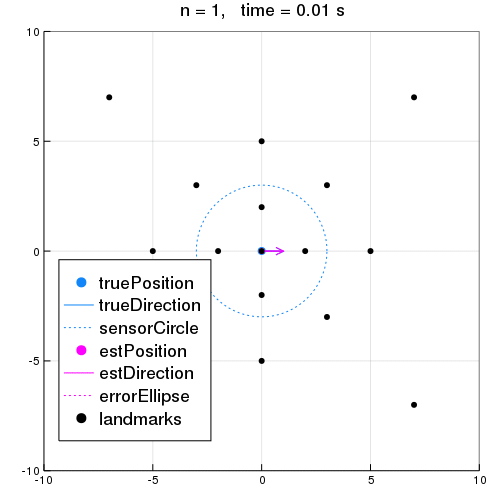

┌ Info: Saved animation to 
│   fn = /Users/hasesuns/Documents/Study/2018-11_ProbabilisticRobotics/Plots_Extended_Kalman.gif
└ @ Plots /Users/hasesuns/.julia/packages/Plots/47Tik/src/animation.jl:90


In [14]:
trueStateVal = StateVal([],[],[]);
estStateVal = StateVal([],[],[]);
dt =　0.01;

@time trueStateValMatrix, estStateValMatrix, xEllipseMatrix, yEllipseMatrix, landmarks, sensorRadius = simulation(dt)

trueStateVal.posx = trueStateValMatrix[:,1];
trueStateVal.posy = trueStateValMatrix[:,2];
trueStateVal.θ = trueStateValMatrix[:,3];

estStateVal.posx = estStateValMatrix[:,1];
estStateVal.posy = estStateValMatrix[:,2];
estStateVal.θ = estStateValMatrix[:,3];


giffile = "Plots_Extended_Kalman.gif"

plots_makegif(giffile, trueStateVal, estStateVal, xEllipseMatrix, yEllipseMatrix, landmarks, sensorRadius, dt);
displayfile("image/gif", giffile);

truePosition   : ロボットの実際の位置

trueDirection  : ロボットの実際の方向

sensorCircle   : ロボットが観測できる範囲

estPosition    : ロボットの推定位置

trueDirection  : ロボットの推定方向

errorEllipse    : 推定の誤差楕円

landmarks     : 目印
